# Visualization
* 대상지 주요 정보 정리(교통량, 속도, 차로변경 등)
* 시각화
    * 시공도
    * SSM 평균치 히트맵
    * 등고선

# Import

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import warnings
import csv
import os

import math # arctangent; math.atan 사용 목적
import statistics

from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as po

import matplotlib.pyplot  as plt
import seaborn as sns

# Load Dataset

In [2]:
working_dir = 'D:/OneDrive - 연세대학교 (Yonsei University)/Projects/Yonsei_TELab/011_SSM실증분석_230315-/'

## 공사구간의 합류 구간

In [3]:
folder_name = 'Dataset/03_SSM'
folder_dir = os.path.join(working_dir, folder_name)

file_name = 'merging_type1_06frm_0.20sec.csv'
file_path = os.path.join(folder_dir, file_name)

In [4]:
df = pd.read_csv(file_path, encoding = 'cp949')

In [5]:
df.head(3)

,Unnamed: 0.1,Unnamed: 0,Vehicle ID,frame,Total Frames,Global Time (Epoch Time),local_x,local_y,V_len,V_wid,...,T2_T,ACT_T,TIT_0,MTIT_0,TIT2_0,TIT2_L,TIT2_R,ACTIT_0,ACTIT_L,ACTIT_R
0,0,0,8,636,46,46821200,39.581772,10.564293,7.352372,3.095736,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,8,642,52,46821400,44.366989,10.657507,7.352372,3.095736,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,8,648,58,46821600,49.125137,10.723641,7.352372,3.095736,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
len(df)

9677

# 문제차량 SSM Profile 조회
* TTC, MTTC, T2, ACT

In [7]:
df.dropna(subset = 'ACT_0').sort_values(by = 'ACT_0')['Vehicle ID'][:30].unique()

C:\Users\User\AppData\Local\Temp\ipykernel_13668\3787696309.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df.dropna(subset = 'ACT_0').sort_values(by = 'ACT_0')['Vehicle ID'][:30].unique()


array([1392,  814, 1613, 1069, 1144,  532,  679,  906,  212,  208, 1084,
        870, 1370, 1123,  133,  965,  539,  542, 1387, 1275,  538,  999,
       1006], dtype=int64)

In [16]:
df.sort_values(by = 'TTC_0')[:30]['Vehicle ID'].unique()

#> 1477은 25609 프레임(13:40) 무렵부터 U3으로 빠졌음
#> 1405 : 23507 프레임(13:03 무렵부터 )U3으로 빠졌음
#> 1013 : 17537 프레임(09:44) 즈음 U2로 빠짐
#> 707 : 11149 프레임(06:11) 에U2로 빠짐
#> 1605 : 26041 프레임(14:28)에 U3으로 빠짐
#> 1397 : 23435 프레임(13:01)에 U3으로 빠짐

array([ 539, 1393,  965,  999, 1387], dtype=int64)

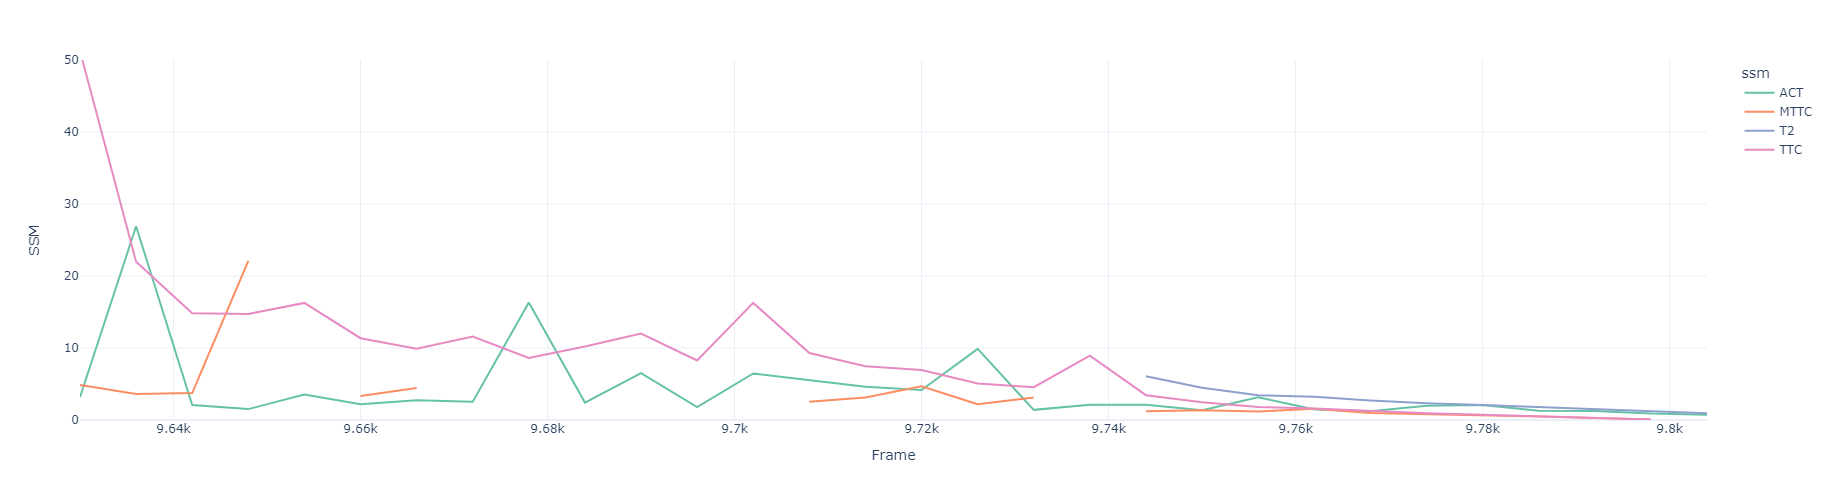

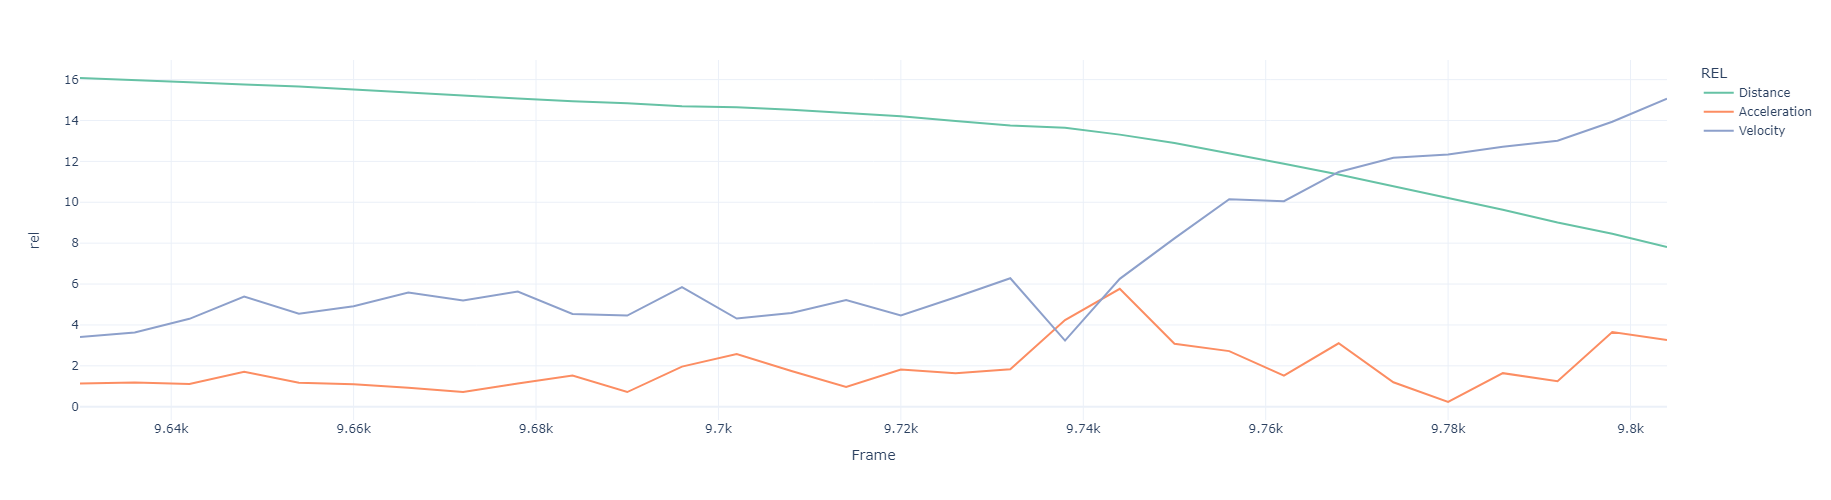

In [17]:
Vehicle_ID = 539

pv = pd.pivot_table(df[df['Vehicle ID'] == Vehicle_ID],
               index = ['Vehicle ID', 'frame'],
               values = ['TTC_0', 'MTTC_0', 'T2_0', 'ACT_0'])

pv.reset_index(inplace = True)
pv.rename({'TTC_0' : 'SSM_TTC', 'MTTC_0' : 'SSM_MTTC', 'T2_0' : 'SSM_T2', 'ACT_0' : 'SSM_ACT'}, axis = 1, inplace = True)
pv = pd.wide_to_long(pv, stubnames = ['SSM'], i = ['Vehicle ID', 'frame'], j = 'ssm', sep = '_', suffix = r'\w+').reset_index()

fig = px.line(pv, x = 'frame', y = 'SSM', color = 'ssm',
              template = 'plotly_white', 
              color_discrete_sequence = px.colors.qualitative.Set2,
              #title = f'Vehicle Trajectory : 공사구간 2개 차로 합류지점', 
              width = 1200, height = 500)

#fig.update_layout(showlegend = False)
fig.update_xaxes(title_text = 'Frame')
fig.update_yaxes(title_text = 'SSM', range = [0, 50])

fig.show()

#relative = 'LV0_relative_velocity'

pv2 = pd.pivot_table(df[df['Vehicle ID'] == Vehicle_ID],
               index = ['Vehicle ID', 'frame', 'LV0_ID'],
               values = ['LV0_D', 'LV0_rel_velocity', 'LV0_rel_acc'])
pv2.reset_index(inplace = True)
pv2.rename({'LV0_D' : 'rel_Distance', 'LV0_rel_velocity' : 'rel_Velocity', 'LV0_rel_acc' : 'rel_Acceleration'}, axis = 1, inplace = True)
pv2 = pd.wide_to_long(pv2, stubnames = ['rel'], i = ['Vehicle ID', 'frame', 'LV0_ID'], j = 'REL', sep = '_', suffix = r'\w+').reset_index()

fig2 = px.line(pv2, x = 'frame', y = 'rel', color = 'REL',
              template = 'plotly_white',
              color_discrete_sequence = px.colors.qualitative.Set2,
              #title = f'Vehicle Trajectory : 공사구간 2개 차로 합류지점', 
              width = 1200, height = 500)

fig2.update_xaxes(title_text = 'Frame')
#fig2.update_yaxes(title_text = relative)

fig2.show()

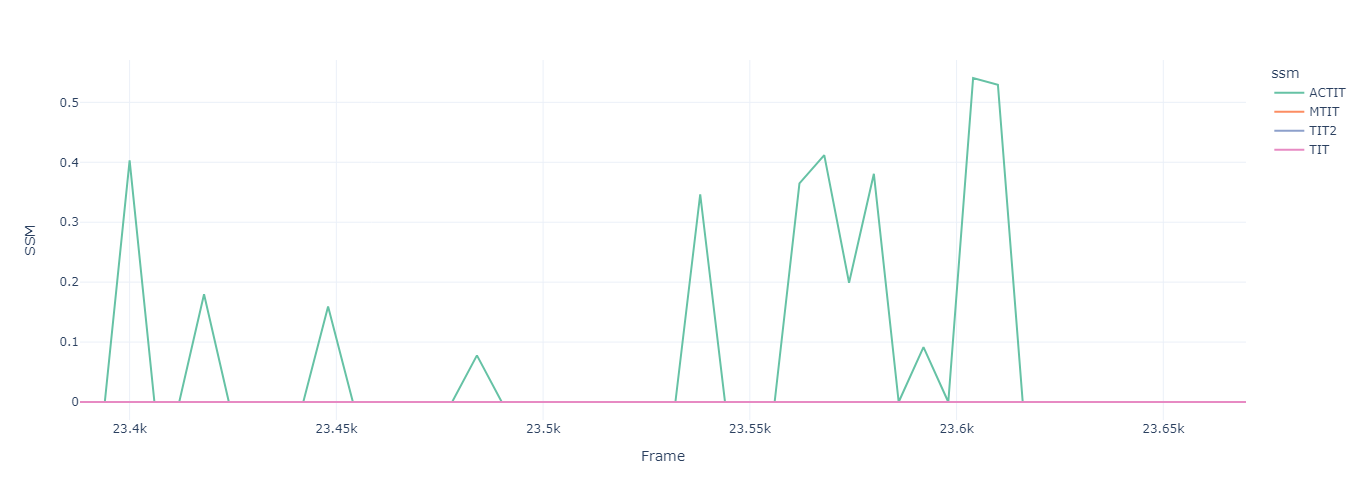

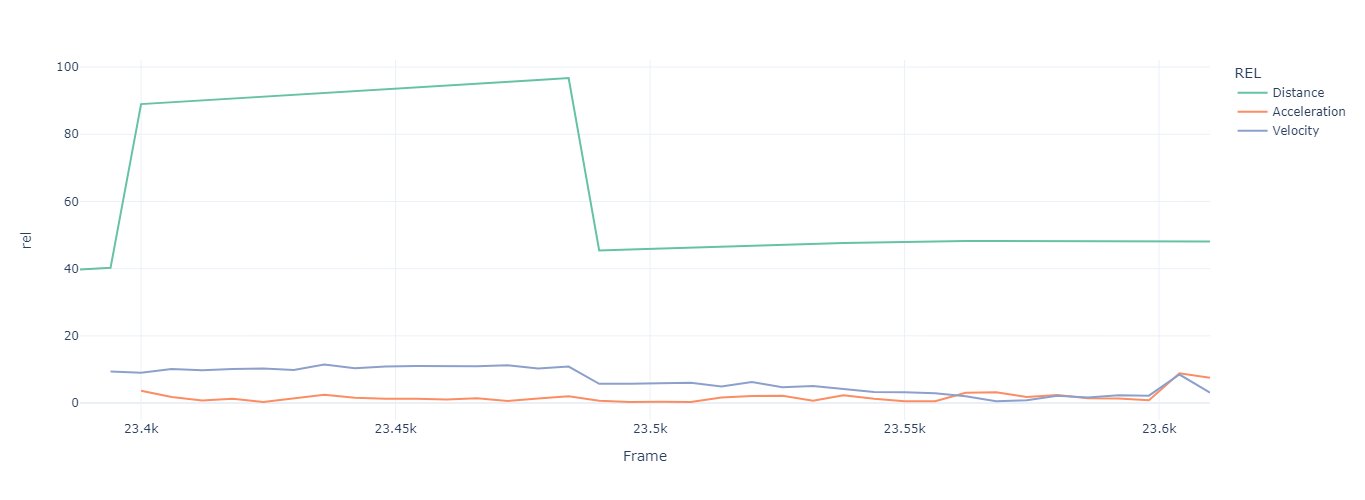

In [10]:
Vehicle_ID = 1392

pv = pd.pivot_table(df[df['Vehicle ID'] == Vehicle_ID],
               index = ['Vehicle ID', 'frame'],
               values = ['TIT_0', 'MTIT_0', 'TIT2_0', 'ACTIT_0'])

pv.reset_index(inplace = True)
pv.rename({'TIT_0' : 'SSM_TIT', 'MTIT_0' : 'SSM_MTIT', 'TIT2_0' : 'SSM_TIT2', 'ACTIT_0' : 'SSM_ACTIT'}, axis = 1, inplace = True)
pv = pd.wide_to_long(pv, stubnames = ['SSM'], i = ['Vehicle ID', 'frame'], j = 'ssm', sep = '_', suffix = r'\w+').reset_index()

fig = px.line(pv, x = 'frame', y = 'SSM', color = 'ssm',
              template = 'plotly_white', 
              color_discrete_sequence = px.colors.qualitative.Set2,
              #title = f'Vehicle Trajectory : 공사구간 2개 차로 합류지점', 
              width = 1200, height = 500)

#fig.update_layout(showlegend = False)
fig.update_xaxes(title_text = 'Frame')
fig.update_yaxes(title_text = 'SSM')#, range = [0, 50])

fig.show()

#relative = 'LV0_relative_velocity'

pv2 = pd.pivot_table(df[df['Vehicle ID'] == Vehicle_ID],
               index = ['Vehicle ID', 'frame', 'LV0_ID'],
               values = ['LV0_D', 'LV0_rel_velocity', 'LV0_rel_acc'])
pv2.reset_index(inplace = True)
pv2.rename({'LV0_D' : 'rel_Distance', 'LV0_rel_velocity' : 'rel_Velocity', 'LV0_rel_acc' : 'rel_Acceleration'}, axis = 1, inplace = True)
pv2 = pd.wide_to_long(pv2, stubnames = ['rel'], i = ['Vehicle ID', 'frame', 'LV0_ID'], j = 'REL', sep = '_', suffix = r'\w+').reset_index()

fig2 = px.line(pv2, x = 'frame', y = 'rel', color = 'REL',
              template = 'plotly_white',
              color_discrete_sequence = px.colors.qualitative.Set2,
              #title = f'Vehicle Trajectory : 공사구간 2개 차로 합류지점', 
              width = 1200, height = 500)

fig2.update_xaxes(title_text = 'Frame')
#fig2.update_yaxes(title_text = relative)

fig2.show()

In [11]:
df.sort_values(by = 'ACT_L')[:30]['Vehicle ID'].unique()

array([ 897,  927,   15, 1393, 1118,  207,  538,  968,  998, 1274,  539,
        262,  298,  852,  847,  529], dtype=int64)

In [12]:
df

,Unnamed: 0.1,Unnamed: 0,Vehicle ID,frame,Total Frames,Global Time (Epoch Time),local_x,local_y,V_len,V_wid,...,T2_T,ACT_T,TIT_0,MTIT_0,TIT2_0,TIT2_L,TIT2_R,ACTIT_0,ACTIT_L,ACTIT_R
0,0,0,8,636,46,46821200,39.581772,10.564293,7.352372,3.095736,...,NaN,NaN,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,1,1,8,642,52,46821400,44.366989,10.657507,7.352372,3.095736,...,NaN,NaN,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,2,2,8,648,58,46821600,49.125137,10.723641,7.352372,3.095736,...,NaN,NaN,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,3,3,8,654,64,46821800,53.936234,10.796314,7.352372,3.095736,...,NaN,NaN,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,4,4,8,660,70,46822000,58.742111,10.859347,7.352372,3.095736,...,NaN,NaN,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9672,9672,9672,1615,26856,271,47695200,210.929836,14.637943,5.804504,2.192813,...,NaN,NaN,0.0,0.192573,0.0,0.0,0.0,0.176066,0.0,0.0
9673,9673,9673,1615,26862,277,47695400,215.940111,14.743855,5.804504,2.192813,...,NaN,NaN,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
9674,9674,9674,1615,26868,283,47695600,221.050823,14.736782,5.804504,2.192813,...,NaN,NaN,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
9675,9675,9675,1615,26874,289,47695800,226.076717,14.734020,5.804504,2.192813,...,NaN,NaN,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


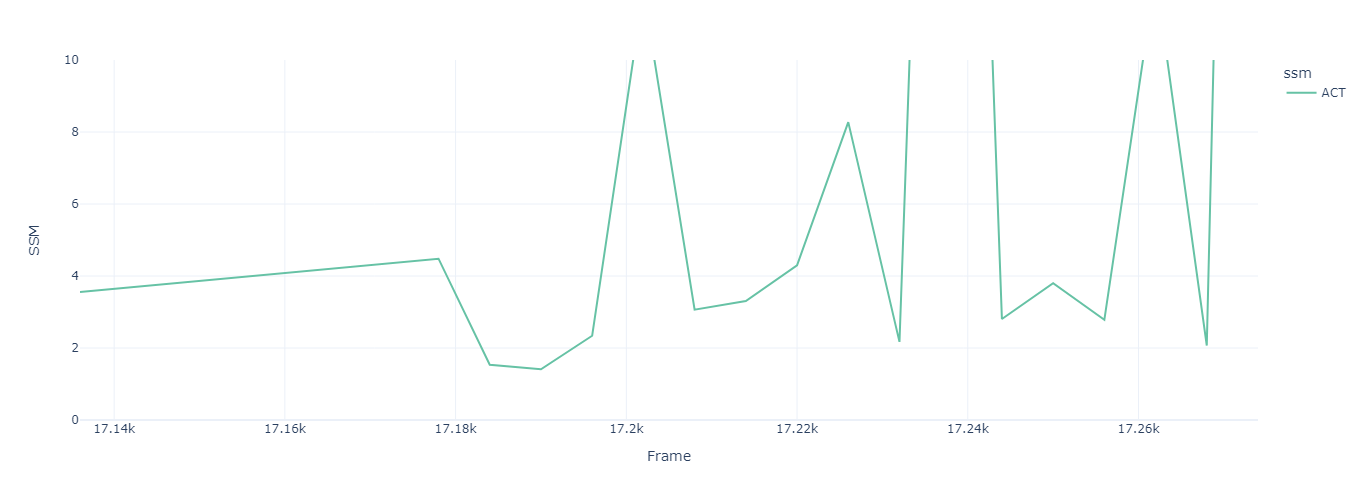

KeyError: 'LVL_relative_velocity'

In [13]:
Vehicle_ID = 983

pv = pd.pivot_table(df[df['Vehicle ID'] == Vehicle_ID],
               index = ['Vehicle ID', 'frame'],
               values = ['T2_L', 'ACT_L'])

pv.reset_index(inplace = True)
pv.rename({'T2_L' : 'SSM_T2', 'ACT_L' : 'SSM_ACT'}, axis = 1, inplace = True)
pv = pd.wide_to_long(pv, stubnames = ['SSM'], i = ['Vehicle ID', 'frame'], j = 'ssm', sep = '_', suffix = r'\w+').reset_index()

fig = px.line(pv, x = 'frame', y = 'SSM', color = 'ssm',
              template = 'plotly_white', 
              color_discrete_sequence = px.colors.qualitative.Set2,
              #title = f'Vehicle Trajectory : 공사구간 2개 차로 합류지점', 
              width = 1200, height = 500)

#fig.update_layout(showlegend = False)
fig.update_xaxes(title_text = 'Frame')
fig.update_yaxes(title_text = 'SSM', range = [0, 10])

fig.show()


pv2 = pd.pivot_table(df[df['Vehicle ID'] == Vehicle_ID],
               index = ['Vehicle ID', 'frame', 'LVL_ID'],
               values = ['LVL_D', 'LVL_relative_velocity', 'LVL_relative_acc'])
pv2.reset_index(inplace = True)
pv2.rename({'LVL_D' : 'rel_Distance', 'LVL_relative_velocity' : 'rel_Velocity', 'LVL_relative_acc' : 'rel_Acceleration'}, axis = 1, inplace = True)
pv2 = pd.wide_to_long(pv2, stubnames = ['rel'], i = ['Vehicle ID', 'frame', 'LVL_ID'], j = 'REL', sep = '_', suffix = r'\w+').reset_index()

fig2 = px.line(pv2, x = 'frame', y = 'rel', color = 'REL',
              template = 'plotly_white',
              color_discrete_sequence = px.colors.qualitative.Set2,
              #title = f'Vehicle Trajectory : 공사구간 2개 차로 합류지점', 
              width = 1200, height = 500)

fig2.update_xaxes(title_text = 'Frame')
#fig2.update_yaxes()

fig2.show()

In [ ]:
df.sort_values(by = 'ACT_R')[:30]['Vehicle ID'].unique()

In [ ]:
Vehicle_ID = 749

pv = pd.pivot_table(df[df['Vehicle ID'] == Vehicle_ID],
               index = ['Vehicle ID', 'frame'],
               values = ['T2_R', 'ACT_R'])

pv.reset_index(inplace = True)
pv.rename({'T2_R' : 'SSM_T2', 'ACT_R' : 'SSM_ACT'}, axis = 1, inplace = True)
pv = pd.wide_to_long(pv, stubnames = ['SSM'], i = ['Vehicle ID', 'frame'], j = 'ssm', sep = '_', suffix = r'\w+').reset_index()

fig = px.line(pv, x = 'frame', y = 'SSM', color = 'ssm',
              template = 'plotly_white', 
              color_discrete_sequence = px.colors.qualitative.Set2,
              #title = f'Vehicle Trajectory : 공사구간 2개 차로 합류지점', 
              width = 1200, height = 500)

#fig.update_layout(showlegend = False)
fig.update_xaxes(title_text = 'Frame')
fig.update_yaxes(title_text = 'SSM')#, range = [0, 50])

fig.show()


pv2 = pd.pivot_table(df[df['Vehicle ID'] == Vehicle_ID],
               index = ['Vehicle ID', 'frame', 'LVR_ID'],
               values = ['LVR_D', 'LVR_relative_velocity', 'LVR_relative_acc'])
pv2.reset_index(inplace = True)
pv2.rename({'LVR_D' : 'rel_Distance', 'LVR_relative_velocity' : 'rel_Velocity', 'LVR_relative_acc' : 'rel_Acceleration'}, axis = 1, inplace = True)
pv2 = pd.wide_to_long(pv2, stubnames = ['rel'], i = ['Vehicle ID', 'frame', 'LVR_ID'], j = 'REL', sep = '_', suffix = r'\w+').reset_index()

fig2 = px.line(pv2, x = 'frame', y = 'rel', color = 'REL',
              template = 'plotly_white',
              color_discrete_sequence = px.colors.qualitative.Set2,
              #title = f'Vehicle Trajectory : 공사구간 2개 차로 합류지점', 
              width = 1200, height = 500)

fig2.update_xaxes(title_text = 'Frame')
fig2.update_yaxes(title_text = relative)

fig2.show()

# Basic Information

## 기초통계량

In [ ]:
var_list = ['velocity', 'acc']
SSM_list = ['TTC_0', 'MTTC_0', 'T2_0', 'ACT_0', 'T2_L', 'ACT_L', 'T2_R',  'ACT_R']

In [ ]:
df[var_list+SSM_list].describe().round(4)

## 필요함수 정의

In [12]:
# 조화평균 함수
harmonic = lambda x: statistics.harmonic_mean(list(x)) 
harmonic .__name__ = 'harmonic'

In [13]:
# 고유값 개수 산정 함수(유니크)
unq = lambda x: len(x.unique())
unq .__name__ = 'unq'

## 기초 정보 저장
* 각 대상지별 전체 차량대수, 밀도, 공간평균속도(SMS), 교통류율 구하여 저장하기
* `harmonic` 함수 사용 : `harmonic(target1_1_A['Vehicle Velocity(km/h)'])` <- 이런 식으로 쓸 수 있다

In [ ]:
folder_name = 'Result/01_Basic'
result_dir = os.path.join(working_dir, folder_name)

os.makedirs(result_dir, exist_ok = True) # 해당 경로가 없을 시 폴더 생성, 존재할 경우 건너뛰기

In [ ]:
frame_rate = 30
num = file_name[:-4]
    
if len(df) > 0:

    tmsec = (df['frame'].max() - df['frame'].min())/30 # 해당 파일 총관측시간(초)

    CF_df = df[df['LC_CF'] == 'CF'] # Car following 차량만 필터링함
    LC_df = df[df['LC_CF'] == 'LC'] # Lane change 차량만 필터링함

    ############################### 전체 차량 대상 통계 ############################################################################

    ###############   총 교통량, 교통류율, 밀도 등 #####################
    total_veh = len(df['Vehicle ID'].unique()) # 총 차량대수
    total_SMS = harmonic(df['velocity']) # 전체 차량의 공간평균속도(SMS)
    lane_count = len(df['Lane Identification'].unique()) # 차로 개수
    total_flowrate = total_veh/tmsec * 3600 # tmsec은 초 단위이므로, 시(h, 3600s) 단위로 변경해야 하기 때문임

    ###############  차로별 교통량, 교통류율, SMS 등 #####################

    pv_veh_lane = pd.pivot_table(df,
                             index = ['Lane_record'],
                             values = ['Vehicle ID', 'velocity', 'acc'],
                             aggfunc = {'Vehicle ID': unq, 'velocity': harmonic, 'acc' : 'mean'})

    pv_veh_lane.reset_index(inplace = True)
    pv_veh_lane['교통류율(vph)'] = pv_veh_lane['Vehicle ID'] * 3600/tmsec

    all_total_df = pd.concat([pd.DataFrame(['All Info']), pv_veh_lane], axis = 1)


    ########################### Car Following 차량

    if len(CF_df) > 0:

        CF_total_veh = len(CF_df['Vehicle ID'].unique()) # 총 차량대수
        CF_total_SMS = harmonic(CF_df['velocity']) #차량의 공간평균속도(SMS)
        CF_lane_count = len(CF_df['Lane Identification'].unique()) # 차로 개수
        CF_total_flowrate = CF_total_veh/tmsec * 3600 # tmsec은 초 단위이므로, 시(h, 3600s) 단위로 변경해야 하기 때문임

        CF_pv_veh_lane = pd.pivot_table(CF_df,
                             index = ['Lane_record'],
                             values = ['Vehicle ID', 'velocity', 'acc'],
                             aggfunc = {'Vehicle ID': unq, 'velocity': harmonic, 'acc' : 'mean'})

        CF_pv_veh_lane.reset_index(inplace = True)
        CF_pv_veh_lane['교통류율(vph)'] = CF_pv_veh_lane['Vehicle ID'] * 3600/tmsec


    else:
        CF_total_veh = None
        CF_total_SMS = None
        CF_distance = None
        CF_lane_count = 0
        CF_total_pv = None
        CF_veh_by_frame = 0
        CF_density = 0
        CF_total_flowrate = 0
        CF_pv_veh_lane = None
        CF_pivot_df = None

    CF_total_df = pd.concat([pd.DataFrame(['CF Info']), CF_pv_veh_lane], axis = 1)


    ########################### Lane Change 차량

    if len(LC_df) > 0:

        LC_total_veh = len(LC_df['Vehicle ID'].unique()) # 총 차량대수
        LC_total_SMS = harmonic(LC_df['velocity']) #차량의 공간평균속도(SMS)
        LC_lane_count = len(LC_df['Lane Identification'].unique()) # Lanechange 발생 차로 개수
        LC_total_flowrate = LC_total_veh/tmsec * 3600 # tmsec은 초 단위이므로, 시(h, 3600s) 단위로 변경해야 하기 때문임

        LC_pv_veh_lane = pd.pivot_table(LC_df,
                                 index = ['Lane_record'],
                                 values = ['Vehicle ID', 'velocity', 'acc'],
                                 aggfunc = {'Vehicle ID': unq, 'velocity': harmonic, 'acc' : 'mean'})

        LC_pv_veh_lane.reset_index(inplace = True)
        LC_pv_veh_lane['교통류율(vph)'] = LC_pv_veh_lane['Vehicle ID'] * 3600/tmsec

    else:
        LC_total_veh = None
        LC_total_SMS = None
        LC_distance = None
        LC_lane_count = 0
        LC_total_pv = None
        LC_veh_by_frame = 0
        LC_density = 0
        LC_total_flowrate = 0
        LC_pv_veh_lane = None
        LC_pivot_df = None

    LC_total_df = pd.concat([pd.DataFrame(['LC Info']), LC_pv_veh_lane], axis = 0)

    ############### 전부 저장 ######################################################################################

    total_df = pd.DataFrame(data = {
        '항목': ['전체', 'Lanechange(LC)', 'Car Following(CF)'],
        '총 차로수(개)' : [lane_count, lane_count, lane_count],
        '총관측시간(s)': [tmsec, tmsec, tmsec],
        '교통량(veh)': [total_veh, LC_total_veh, CF_total_veh],
        '공간평균속도(km/h)': [round(total_SMS, 2), round(CF_total_SMS, 2), round(CF_total_SMS, 2)],
        '교통류율(vph)': [round(total_flowrate, 2), '', ''],
    })    
    
    # 파일 저장하기
    
    total_df.to_csv('temp1.csv', encoding = 'cp949') # 임시 파일 생성
    all_total_df.to_csv('temp2.csv', encoding = 'cp949')
    CF_total_df.to_csv('temp3.csv', encoding = 'cp949')
    LC_total_df.to_csv('temp4.csv', encoding = 'cp949')
    
    save_file = f'info_{num}.csv'
    save_path = os.path.join(result_dir, save_file)

    file_list = ['temp1.csv', 'temp2.csv', 'temp3.csv', 'temp4.csv']
    name_list = ['전체 교통정보', '전체 차량 정보', 'Car-following 차량 정보', 'Lane-change 차량 정보']

    with open(save_path, 'w') as f: #2-1.병합할할 파일을 열고

        for file, name in zip(file_list, name_list):
            f.write(name)
            f.write('\n')
            if os.path.isfile(file): # 파일이 있으면
                with open(file ,'r') as f2:  # 파일을 엽니다.
                    while True:
                        line = f2.readline() # 대상 파일의 row 1줄을 읽어서 
                        if not line: #row가 없으면 해당 csv 파일 읽기 끝
                            f.write('\n')
                            break

                        f.write(line) #3.읽은 row 1줄을 merge할 파일에 쓴다.
                #print(file.split('\\')[-1] + ' Write complete!')

            else:
                pass

    for file in file_list: # 임시 파일은 삭제해 주도록 한다.
        if os.path.isfile(file):
            os.remove(file)    

    print('>>> All file merge complete <<<')

# 시공도

In [ ]:
df['Time'] = df['frame']/30
fig = px.line(df, x = 'Time', y = 'local_x', color = 'Vehicle ID',
              template = 'plotly_white', 
              color_discrete_sequence = px.colors.qualitative.Set2,
              #title = f'Vehicle Trajectory : 공사구간 2개 차로 합류지점', 
              width = 1200, height = 500)

fig.update_layout(showlegend = False)
fig.update_xaxes(title_text = 'Time(s)')
fig.update_yaxes(title_text = 'Distance(m)')

fig.show()

## 히스토그램

In [ ]:
fig = px.histogram(df[df['TTC_0'] <= 100], x = 'TTC_0')
fig.show()

In [ ]:
fig = px.histogram(df[df['MTTC_0'] <= 20], x = 'MTTC_0')
fig.show()

In [ ]:
fig = px.histogram(df[df['T2_0'] <= 100], x = 'T2_0')
fig.show()

In [ ]:
fig = px.histogram(df[df['T2_L'] <= 20], x = 'T2_L')
fig.show()

In [ ]:
fig = px.histogram(df[df['T2_R'] <= 20], x = 'T2_R')
fig.show()

In [ ]:
from plotly.colors import n_colors
np.random.seed(1)

# 12 sets of normal distributed random data, with increasing mean and standard deviation
data = (np.linspace(1, 2, 12)[:, np.newaxis] * np.random.randn(12, 200) +
            (np.arange(12) + 2 * np.random.random(12))[:, np.newaxis])

colors = n_colors('rgb(5, 200, 200)', 'rgb(200, 10, 10)', 12, colortype='rgb')

fig = go.Figure()
for data_line, color in zip(data, colors):
    fig.add_trace(go.Violin(x=data_line, line_color=color))

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.show()

# Heatmap

In [ ]:
palette_ryb = ['#00b0f0', '#ffff00', '#ff5050'] # 엇갈림구간 프로젝트의 그 삼색팔레트 : 파랑-노랑-빨강
palette_TIT = ['#ffffff', '#ff0000'] # 환색~빨강
#palette_bluewhite = ['#ffffff', '#0054ff'] # 
palette_TTC = ['#ff0000', '#ffffff'] # 빨강~흰색
#palette_whiteblue = ['#0054ff', '#ffffff']


def make_cell(x):
    """x 좌표를 바탕으로 소속 셀 영역 알려줌"""
    
    c = int(x//20)
    
    if c < 10:
        c1 = 'C0' + str(c)
    else:
        c1 = 'C' + str(c)
        
    return c1


def df_to_plotly(pv):
    return {'z': pv.values.tolist(),
            'y': pv['Lane Identification'].tolist(),
            'x': pv.columns.tolist()}

## TTC

In [ ]:
num = file_name[:-4]

SSM = 'TTC_0'

df['num'] = num
delta_local_x = df['delta_local_x'].mean()
df['cell'] = df.apply(lambda x: make_cell(x.local_x), axis = 1)

df = df.replace({'Lane Identification' : {'U1' : 'U01', 'U2' : 'U02', 'U3' : 'U03', 'U4' : 'U04', 'U5' : 'U05', 'U51' : 'U055', 'U6' : 'U06', 'U7' : 'U07', 'U8' : 'U08', 'U9' : 'U09'}})

cell_list = df['cell'].unique()
cell_list.sort()
cell_list = list(cell_list)

df2 = df.dropna(subset = SSM)

if len(df) > 0:

    pv = pd.pivot_table(df2, # 셀별 속도표준편차
               index = 'Lane Identification',
                columns = 'cell',
                values = [SSM],
                aggfunc = {SSM : 'mean'})
    
    pv2 = pv[SSM]

    for cell in cell_list:
        if cell not in pv2.columns:
            pv2[cell] = None # 만약 셀이 없으면 추가해야 한다.

        else:
            pass
        
    pv2.reset_index(inplace = True)
    pv2 = pv2.round(3)
    pv2 = pv2.replace(0, np.NaN) # 0을 Nan으로 교체한다.
    
    pv2 = pv2[cell_list + ['Lane Identification']]
    
    fig = go.Figure(data = go.Heatmap(df_to_plotly(pv2),
                            colorscale = palette_TTC,
                            texttemplate = '%{z}',
                            textfont = {'size' : 18}
                            #zmin = 0, zmax = 10
                            ))
    
    fig.update_layout(yaxis = dict(autorange = 'reversed'), 
                      template = 'plotly_white',
                      title = f'공사구간 : 작업활동구역 직전(완충구간) 평균 {SSM}')

    fig.show()

In [ ]:
pv2

## TIT_sum

In [ ]:
SSM = 'TIT_0'

df['num'] = num

delta_local_x = df['delta_local_x'].mean()
df['cell'] = df.apply(lambda x: make_cell(x.local_x), axis = 1)

df = df.replace({'Lane Identification' : {'U1' : 'U01', 'U2' : 'U02', 'U3' : 'U03', 'U4' : 'U04', 'U5' : 'U05', 'U51' : 'U055', 'U6' : 'U06', 'U7' : 'U07', 'U8' : 'U08', 'U9' : 'U09'}})


cell_list = df['cell'].unique()
cell_list.sort()
cell_list = list(cell_list)

df2 = df.dropna(subset = SSM) # SSM 기준 결측값을 제거한다

if len(df) > 0:

    pv = pd.pivot_table(df2,
               index = 'Lane Identification',
                columns = 'cell',
                values = [SSM],
                aggfunc = {SSM : 'sum'})
    
    pv2 = pv[SSM]

    for cell in cell_list:
        if cell not in pv2.columns:
            pv2[cell] = np.NaN # 만약 셀이 없으면 추가해야 한다.

        else:
            pass

    pv2.reset_index(inplace = True)
    pv2 = pv2.round(3)
    pv2 = pv2.replace(0, np.NaN) # 0을 Nan으로 교체한다.
    # 컬럼을 셀 번호 이름대로 정렬해준다. 이때 절때 Heatmap의 Categoryascending을 해 주면 안된다는 것이다.
    pv2 = pv2[cell_list + ['Lane Identification']]


    fig = go.Figure(data = go.Heatmap(df_to_plotly(pv2),
                            colorscale = palette_TIT,
                            texttemplate = '%{z}',
                            textfont = {'size' : 18}
                            #zmin = 0, zmax = 10
                            ))
    
    fig.update_layout(yaxis = dict(autorange = 'reversed'), 
                      template = 'plotly_white',
                      title = f'공사구간 : 작업활동구역 직전(완충구간) 합 {SSM}')
    
    fig.show()

## TIT_mean

In [ ]:
SSM = 'ACTIT_min'

df['num'] = num

delta_local_x = df['delta_local_x'].mean()
df['cell'] = df.apply(lambda x: make_cell(x.local_x), axis = 1)

df = df.replace({'Lane Identification' : {'U1' : 'U01', 'U2' : 'U02', 'U3' : 'U03', 'U4' : 'U04', 'U5' : 'U05', 'U51' : 'U055', 'U6' : 'U06', 'U7' : 'U07', 'U8' : 'U08', 'U9' : 'U09'}})


cell_list = df['cell'].unique()
cell_list.sort()
cell_list = list(cell_list)

df2 = df.dropna(subset = SSM) # SSM 기준 결측값을 제거한다

if len(df) > 0:

    pv = pd.pivot_table(df2,
               index = 'Lane Identification',
                columns = 'cell',
                values = [SSM],
                aggfunc = {SSM : 'sum'})
    
    pv2 = pv[SSM]

    for cell in cell_list:
        if cell not in pv2.columns:
            pv2[cell] = np.NaN # 만약 셀이 없으면 추가해야 한다.

        else:
            pass

    pv2.reset_index(inplace = True)
    pv2 = pv2.round(3)
    pv2 = pv2.replace(0, np.NaN) # 0을 Nan으로 교체한다.
    # 컬럼을 셀 번호 이름대로 정렬해준다. 이때 절때 Heatmap의 Categoryascending을 해 주면 안된다는 것이다.
    pv2 = pv2[cell_list + ['Lane Identification']]
    
    
    pv_veh = pd.pivot_table(df,
           index = 'Lane Identification',
            columns = 'cell',
            values = ['Vehicle ID'],
            aggfunc = {'Vehicle ID' : lambda x: len(x.unique())})

    for cell in cell_list:
        if cell not in pv_veh['Vehicle ID'].columns:
            pv_veh['Vehicle ID'][cell] = None # 만약 셀이 없으면 추가해야 한다.

        else:
            pass

    pv_veh = pv_veh['Vehicle ID'].reset_index()
    pv_veh = pv_veh[cell_list + ['Lane Identification']]

    pv3 = pv2[cell_list]/pv_veh[cell_list]
    pv3['Lane Identification'] = ['U01', 'U02']
    pv3 = pv3.round(3)
    

    fig = go.Figure(data = go.Heatmap(df_to_plotly(pv3),
                            colorscale = palette_TIT,
                            texttemplate = '%{z}',
                            textfont = {'size' : 18},
                            zmin = 0, zmax = 1
                            ))
    
    fig.update_layout(yaxis = dict(autorange = 'reversed'), 
                      template = 'plotly_white',
                      title = f'공사구간 : 작업활동구역 직전(완충구간) {SSM}')
    
    fig.show()

In [ ]:
pv2

In [ ]:
pv_veh

# TTC profile

# Coutour

# Violin

In [ ]:
df2 = df[df[SSM] <= 50]
df2['num'] = num

fig = go.Figure()

fig.add_trace(go.Violin(x = df2['num'][(df2['LC_CF'] == 'CF')],
                        y = df2[SSM][(df2['LC_CF'] == 'CF')],
                        legendgroup = 'CF', scalegroup = 'CF', #name = num,
                        side = 'negative',
                        line_color = 'blue',
                        points = False))

fig.add_trace(go.Violin(x = df2['num'][(df2['LC_CF'] == 'LC')],
                        y = df2[SSM][(df2['LC_CF'] == 'LC')],
                        legendgroup = 'LC', scalegroup = 'LC', #name = num,
                        side = 'positive',
                        line_color = 'orange',
                        points = False))

fig.update_traces(meanline_visible = True) #box_visible = True
fig.update_layout(violingap = 0, violinmode = 'overlay', showlegend = False)

fig.update_layout(width = 500, height = 400,
                  #minreducedwidth = (150 * len(df_list)), minreducedheight = 1000,
                  #margin = dict(b = 300, t = 0, l = 0, r = 0),
                  #plot_bgcolor = 'white',
                  #paper_bgcolor = 'rgba(0, 0, 0, 0)',
                  xaxis = dict(range = [-1, 1])
                 )

#fig.update_xaxes(tickangle = 90) # x축 범례 글자 90도 회전하라는 의미
#fig.update_yaxes(range = [-0.4, 10]) # y축 범위
fig.add_hline(y = 0, line_width = 3, line_color = 'red')

fig.show()